In [22]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision.transforms import v2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import umap
from embed_time.model_VAE_resnet18 import VAEResNet18
from embed_time.neuromast import NeuromastDatasetTest, NeuromastDatasetTrain, NeuromastDatasetTrain_T10
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score
import seaborn as sns

In [1]:
def load_checkpoint(checkpoint_path, model, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint['epoch']

In [2]:
def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [10]:
# Model Evaluation Function
def LS_sampling(model, dataloader, device):
    model.eval()
    total_loss = total_mse = total_kld = 0
    all_latent_vectors = []
    all_metadata = []
    
    with torch.no_grad():
        for idx, (batch, label) in enumerate(dataloader):
            data = batch.to(device)
            
            recon_batch, mu, logvar = model(data)
            for i in range(5):
                z = reparameterize(mu, logvar)
                all_latent_vectors.append(z.cpu())    

                all_metadata.extend(label.tolist())

            mse = F.mse_loss(recon_batch, data, reduction='sum')
            kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = mse + kld * 1e-7
            
            total_loss += loss.item()
            total_mse += mse.item()
            total_kld += kld.item()
            print(f'[{idx}/{len(dataloader)}] Loss: {loss.item():.3f} | MSE: {mse.item():.3f} | KLD: {kld.item():.3f}', end='\r')
            

    
    avg_loss = total_loss / len(dataloader.dataset)
    avg_mse = total_mse / len(dataloader.dataset)
    avg_kld = total_kld / len(dataloader.dataset)
    latent_vectors = torch.cat(all_latent_vectors, dim=0)
    
    return avg_loss, avg_mse, avg_kld, latent_vectors, all_metadata

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Model initialization and loading
model = VAEResNet18(nc = 1, z_dim = 22 ).to(device)
checkpoint_dir = "/mnt/efs/dlmbl/G-et/checkpoints/static/Akila/20240903z_dim-22_lr-0.0001_beta-1e-07/_epoch_6/"

checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
model, epoch = load_checkpoint(checkpoint_path, model, device)
model = model.to(device)

dataset_train = NeuromastDatasetTrain_T10()


dataloader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=8)


/tmp/ipykernel_412548/687843937.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [12]:
# Model evaluation
print("Evaluating on training data...")
train_loss, train_mse, train_kld, train_latents, train_metadata = LS_sampling(model, dataloader_train, device)
print(f"Training - Loss: {train_loss:.4f}, MSE: {train_mse:.4f}, KLD: {train_kld:.4f}")


Evaluating on training data...
Training - Loss: 23.6150, MSE: 23.6150, KLD: 156.5760


In [19]:
# Convert lists to numpy arrays
latent_vectors = np.array(train_latents)
metadata = np.array(train_metadata)
print(latent_vectors.shape, metadata.shape)

# Encode metadata if not already done
label_encoder = LabelEncoder()
metadata_encoded = label_encoder.fit_transform(metadata)

# Flatten each latent vector to combine the channels with spatial dimensions
latent_vectors_reshaped = latent_vectors.reshape(latent_vectors.shape[0], -1)
print(latent_vectors_reshaped.shape)



# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(latent_vectors_reshaped, metadata_encoded, test_size=0.3, random_state=42)




(1530, 22, 16, 16) (1530,)
(1530, 5632)


In [20]:
# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
y_pred = rf.predict(X_test)
print("Accuracy:", balanced_accuracy_score(y_test, y_pred)) #The best value is 1 and the worst value is 0 when adjusted=False
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["SC", "MC", "HC"]))

Accuracy: 0.841564958339152

Classification Report:
               precision    recall  f1-score   support

          SC       0.94      0.67      0.79       150
          MC       0.70      0.96      0.81       154
          HC       0.99      0.89      0.94       155

    accuracy                           0.84       459
   macro avg       0.88      0.84      0.84       459
weighted avg       0.88      0.84      0.84       459



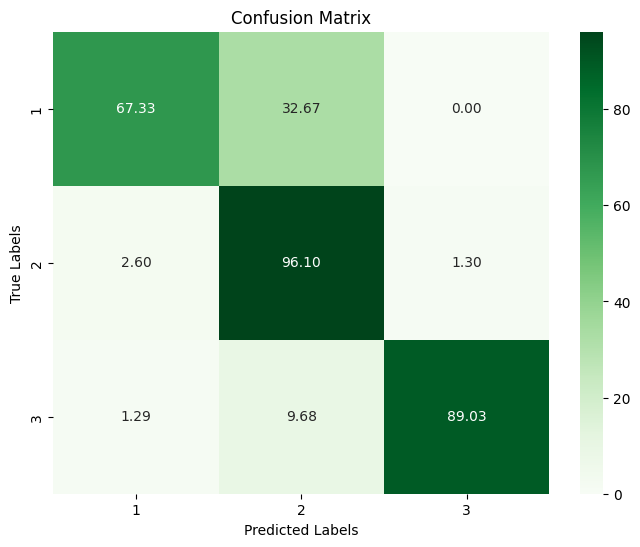

In [53]:
# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
# Calculate percentages
conf_mat_percent = conf_mat / conf_mat.sum(axis=1, keepdims=True) * 100
# Create a custom annotation format to add % symbol
labels = np.asarray([f"{value:.2f}%" for value in conf_mat_percent.flatten()]).reshape(conf_mat.shape)
# Plot the confusion matrix
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_percent, annot=True, fmt='.2f', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
dataset_test = NeuromastDatasetTest()


dataloader_test = DataLoader(dataset_test, batch_size=2, shuffle=True, num_workers=8)
# Model evaluation
print("Evaluating on testing data...")
test_loss, test_mse, test_kld, test_latents, test_metadata = LS_sampling(model, dataloader_test, device)



In [31]:

print(f"Testing - Loss: {test_loss:.4f}, MSE: {test_mse:.4f}, KLD: {test_kld:.4f}")

Testing - Loss: 27.3370, MSE: 27.3370, KLD: 165.5264


In [33]:
# Convert lists to numpy arrays
latent_vectors_test = np.array(test_latents)
metadata_test = np.array(test_metadata)


# Encode metadata if not already done
label_encoder_test = LabelEncoder()
metadata_encoded_test = label_encoder_test.fit_transform(metadata_test)

# Flatten each latent vector to combine the channels with spatial dimensions
latent_vectors_reshaped_test = latent_vectors_test.reshape(latent_vectors_test.shape[0], -1)

y_pred_test = rf.predict(latent_vectors_reshaped_test)
print("Accuracy:", balanced_accuracy_score(metadata_encoded_test, y_pred_test)) #The best value is 1 and the worst value is 0 when adjusted=False
print("\nClassification Report:\n", classification_report(metadata_encoded_test, y_pred_test, target_names=["SC", "MC", "HC"]))

Accuracy: 0.7161839187167981

Classification Report:
               precision    recall  f1-score   support

          SC       0.85      0.54      0.66      1405
          MC       0.41      0.78      0.53       550
          HC       0.80      0.83      0.82       460

    accuracy                           0.65      2415
   macro avg       0.69      0.72      0.67      2415
weighted avg       0.74      0.65      0.66      2415



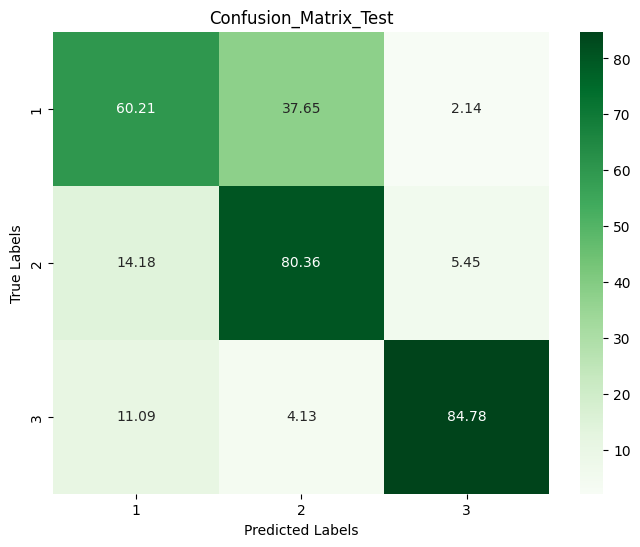

In [52]:
# Generate the confusion matrix
conf_mat = confusion_matrix(metadata_encoded_test, y_pred_test)
# Calculate percentages
conf_mat_percent = conf_mat / conf_mat.sum(axis=1, keepdims=True) * 100
# Create a custom annotation format to add % symbol
labels = np.asarray([f"{value:.2f}%" for value in conf_mat_percent.flatten()]).reshape(conf_mat.shape)
# Plot the confusion matrix
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_percent, annot=True, fmt='.2f', cmap='Greens', xticklabels=label_encoder_test.classes_, yticklabels=label_encoder_test.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion_Matrix_Test')
plt.show()

In [37]:
dataset_train_big = NeuromastDatasetTrain()


dataloader_train_big = DataLoader(dataset_train_big, batch_size=2, shuffle=True, num_workers=8)

# Model evaluation
print("Evaluating on training data...")
train_loss_big, train_mse_big, train_kld_big, train_latents_big, train_metadata_big = LS_sampling(model, dataloader_train_big, device)
print(f"Training_big - Loss: {train_loss_big:.4f}, MSE: {train_mse_big:.4f}, KLD: {train_kld_big:.4f}")


Evaluating on training data...
Training_big - Loss: 23.5543, MSE: 23.5543, KLD: 157.3459


In [38]:


#save the train_latents_big 
file_path = os.path.join(save_dir, 'train_latents_big.npy')
# Assuming latent_train and metadata_train are numpy arrays
np.save(file_path, train_latents_big)
#save the train_metadata_big
file_path_1 = os.path.join(save_dir, 'train_metadata_big.npy')
np.save(file_path_1, train_metadata_big)


In [39]:

#convert lists to numpy arrays
latent_vectors_big = np.array(train_latents_big)
metadata_big = np.array(train_metadata_big)

# Encode metadata if not already done
label_encoder_big = LabelEncoder()
metadata_encoded_big = label_encoder_big.fit_transform(metadata_big)

# Flatten each latent vector to combine the channels with spatial dimensions
latent_vectors_reshaped_big = latent_vectors_big.reshape(latent_vectors_big.shape[0], -1)


# Split data into training and testing sets
X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(latent_vectors_reshaped_big, metadata_encoded_big, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_big, y_train_big)

RandomForestClassifier(random_state=42)

In [40]:
import pickle
save_dir = "/mnt/efs/dlmbl/G-et/data/neuromast/models/"
# Define the full file path
file_path = os.path.join(save_dir, 'random_forest_model_big.pkl')

# Save the model to a .pkl file
with open(file_path, 'wb') as f:
    pickle.dump(rf, f)

Accuracy: 0.8834570802776075

Classification Report:
               precision    recall  f1-score   support

          SC       0.96      0.76      0.85      7732
          MC       0.76      0.99      0.86      7666
          HC       0.98      0.90      0.94      7840

    accuracy                           0.88     23238
   macro avg       0.90      0.88      0.88     23238
weighted avg       0.90      0.88      0.88     23238



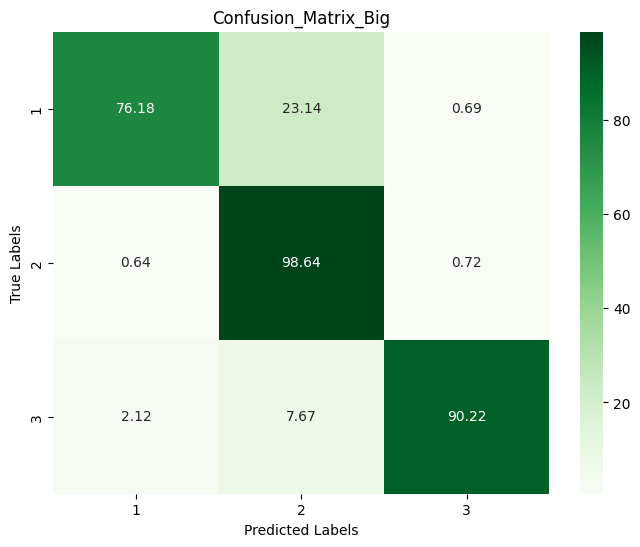

In [43]:

y_pred_big = rf.predict(X_test_big)
print("Accuracy:", balanced_accuracy_score(y_test_big, y_pred_big)) #The best value is 1 and the worst value is 0 when adjusted=False
print("\nClassification Report:\n", classification_report(y_test_big, y_pred_big, target_names=["SC", "MC", "HC"]))

# Generate the confusion matrix

conf_mat = confusion_matrix(y_test_big, y_pred_big)
# Calculate percentages
conf_mat_percent = conf_mat / conf_mat.sum(axis=1, keepdims=True) * 100
# Create a custom annotation format to add % symbol
labels = np.asarray([f"{value:.2f}%" for value in conf_mat_percent.flatten()]).reshape(conf_mat.shape)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_percent, annot=True, fmt='', cmap='Greens', xticklabels=label_encoder_big.classes_, yticklabels=label_encoder_big.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion_Matrix_Big')
plt.show()


Accuracy: 0.7511992273032039

Classification Report:
               precision    recall  f1-score   support

          SC       0.87      0.60      0.71      1405
          MC       0.45      0.80      0.57       550
          HC       0.87      0.85      0.86       460

    accuracy                           0.69      2415
   macro avg       0.73      0.75      0.71      2415
weighted avg       0.77      0.69      0.71      2415



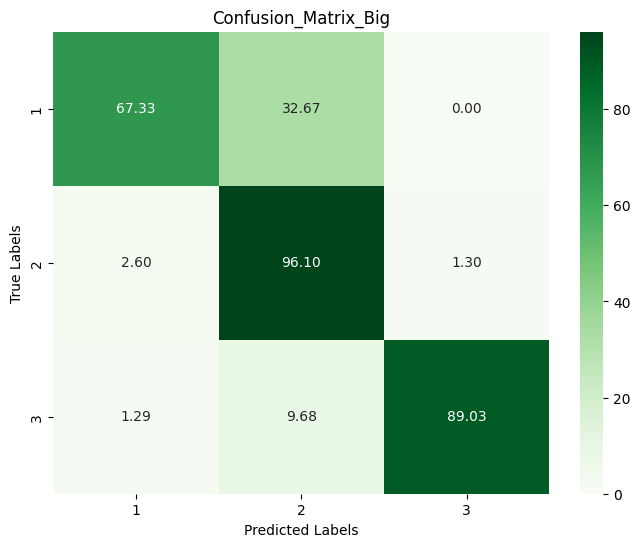

In [49]:
y_pred_test = rf.predict(latent_vectors_reshaped_test)
print("Accuracy:", balanced_accuracy_score(metadata_encoded_test, y_pred_test)) #The best value is 1 and the worst value is 0 when adjusted=False
print("\nClassification Report:\n", classification_report(metadata_encoded_test, y_pred_test, target_names=["SC", "MC", "HC"]))
# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
# Calculate percentages
conf_mat_percent = conf_mat / conf_mat.sum(axis=1, keepdims=True) * 100


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_percent, annot=True, fmt='.2f', cmap='Greens', xticklabels=label_encoder_test.classes_, yticklabels=label_encoder_test.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion_Matrix_Big')
plt.show()